# WebScraping a letting agency site and populating a Database

In this project I shall scrape a local letting agent site. The URL is:
https://www.quicklets.com.mt/long-let-malta

The Webdriver shall first navigate to the homepage. The user shall then be prompted to enter a property type and location. The Webdriver shall detect the number of results generated. The Webdriver shall then attempt to append all results in the page to a table (property city, price and URL), press "Next" to get the next result page and append the next set of results to the table. This shall go on until the the number of rows in the table are either larger or equal to the number of results or else an error occurs. The results shall then be inserted into a Database using SQLite.



> **Set up**

This section sets up the environment.


In [ ]:
#@title
!pip install kora -q
from kora.selenium import wd
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
import cv2
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 




> **Functions**

This section sets up the functions.



In [ ]:
def Home():
    wd.get("https://www.quicklets.com.mt/")
    wd.maximize_window()
  
def ShowScreen():
  wd.save_screenshot("screenshot.png")
  screenshot = cv2.imread("screenshot.png")
  cv2_imshow(screenshot)

def Scroll_down(Num):
   page_body = wd.find_element_by_css_selector("body")
   x=1
   while (x<=Num):
       page_body.send_keys(Keys.ARROW_DOWN)
       x=x+1

def searchProp(inputType,inputLoc):
    inputs1 = wd.find_elements_by_class_name("select2-search__field")
    property_type = inputs1[0]
    location = inputs1[2]

    property_type.send_keys(inputType)
    time.sleep(1)
    selektor = wd.find_elements_by_class_name("select2-results__option")
    selektor[0].click()
    page_body = wd.find_element_by_css_selector("body")
    page_body.click()
    time.sleep(1)

    location.send_keys(inputLoc)
    time.sleep(1)
    selektor = wd.find_elements_by_class_name("select2-results__option")
    selektor[0].click()
    page_body = wd.find_element_by_css_selector("body")
    page_body.click()
    time.sleep(1)

    Scroll_down(3)

    searchBTN = wd.find_elements_by_class_name("btn-search")
    searchBTN[0].click()

def returndat():
    city = wd.find_elements_by_css_selector(".city")
    price = wd.find_elements_by_css_selector(".price")

    citytext = [x.text for x in city]
    linkurl = [x.get_attribute("href") for x in city]
    price = [x.text for x in price]
    price = [x.replace("€", "") for x in price]
    price = [x.replace("/mo", "") for x in price]
    price = [x.replace(",", "") for x in price]
    ls = []

    for x in price:
        try:
            ls.append(int(x))
        except:
            ls.append(0)

    mydata = pd.DataFrame({
        "city": citytext,
        "price": ls,
        "linkurl": linkurl
    })
    return (mydata)



> **Search Property**



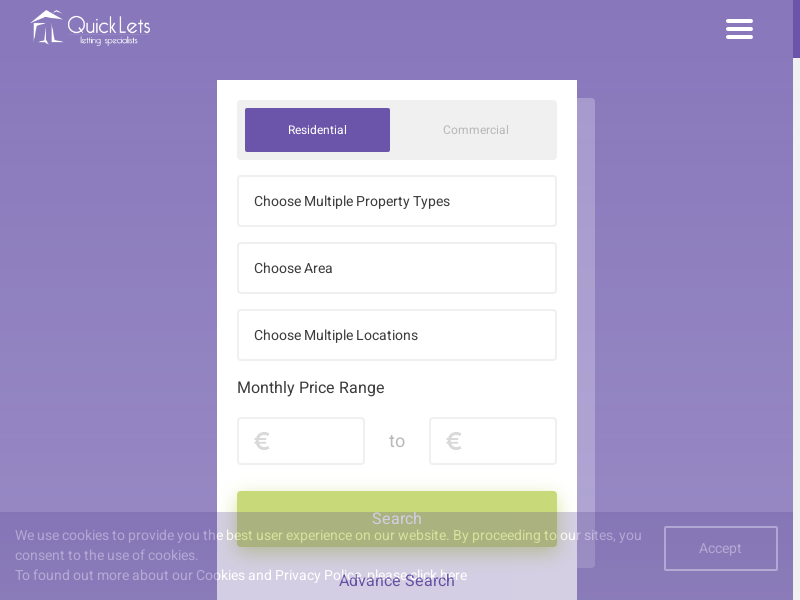

In [ ]:
Home()
ShowScreen()

In [ ]:
PropType = input("Please input property to search: ")
PropLoc= input("Please input location to search: ")

Please input property to search: Penthouse
Please input location to search: Sliema


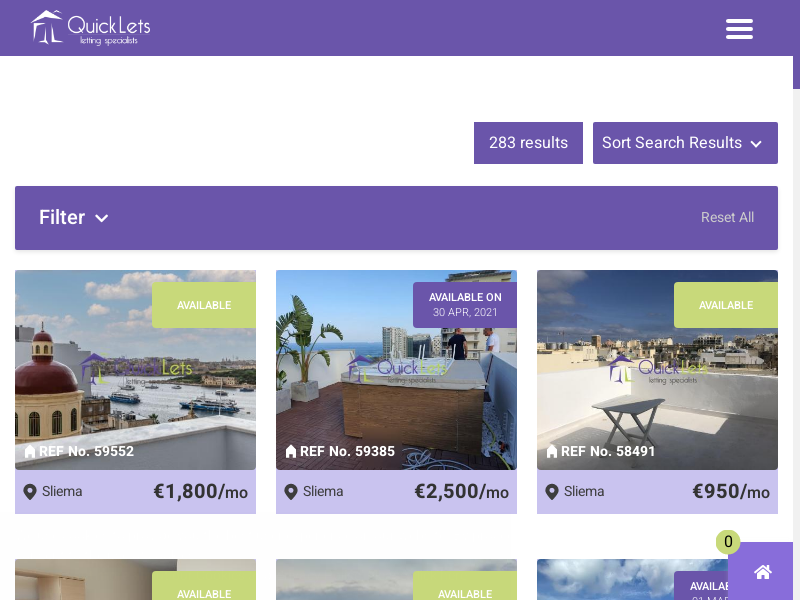

A total of 283 proprties have been found


In [ ]:
searchProp(PropType,PropLoc)
resultNum = int(wd.find_element_by_class_name("result").text.split(" ")[0])
ShowScreen()
print("A total of " + str(resultNum) + " proprties have been found")

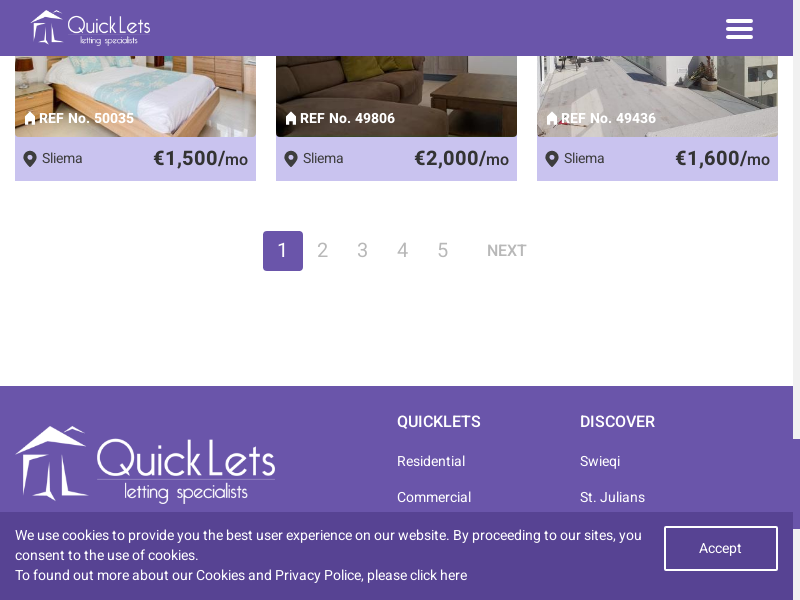

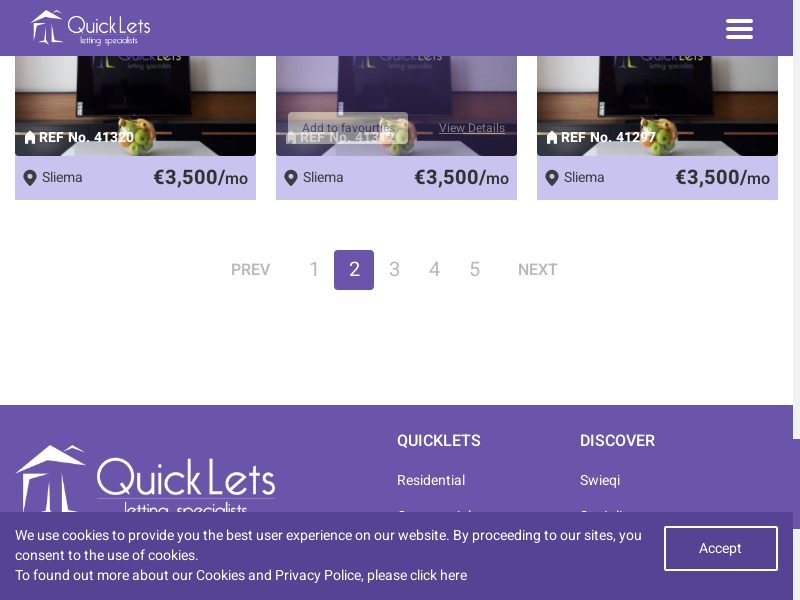

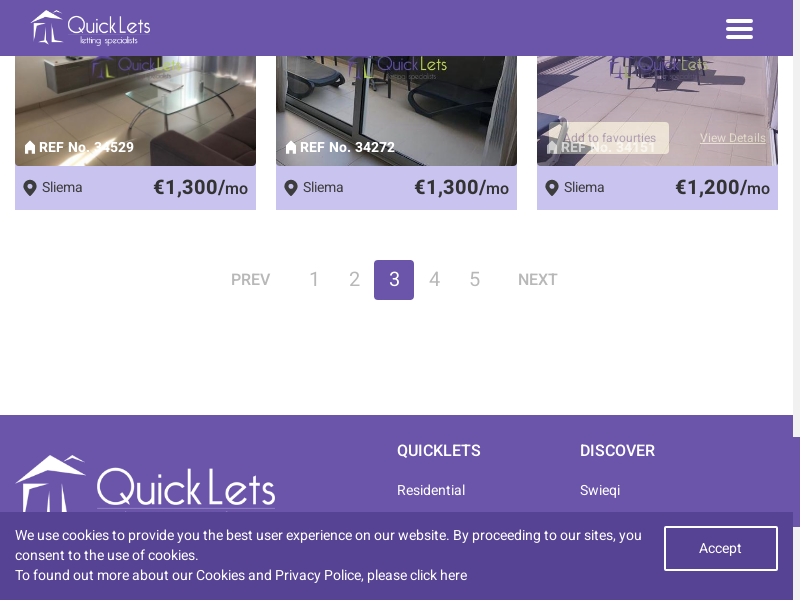

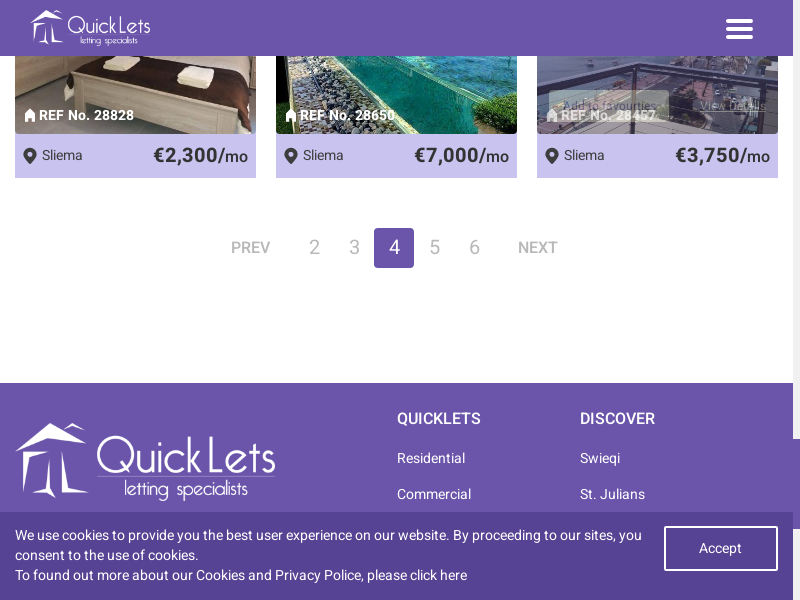

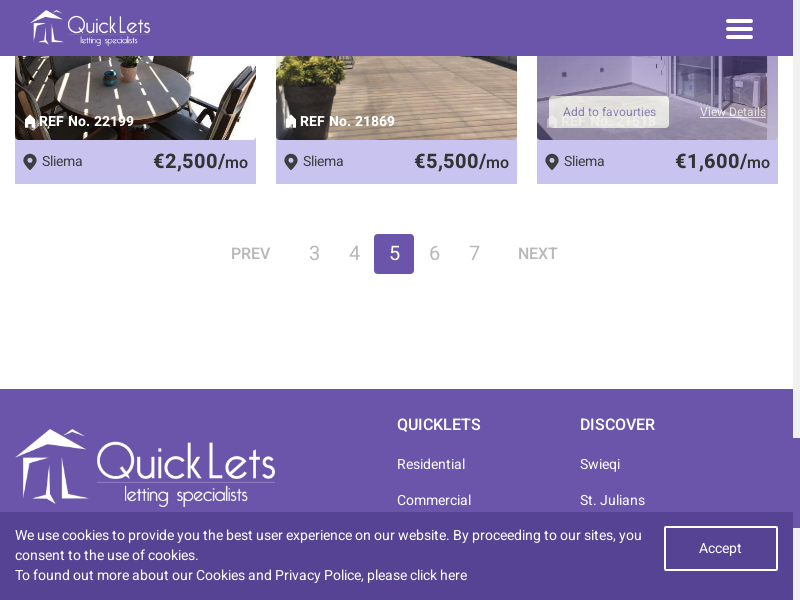

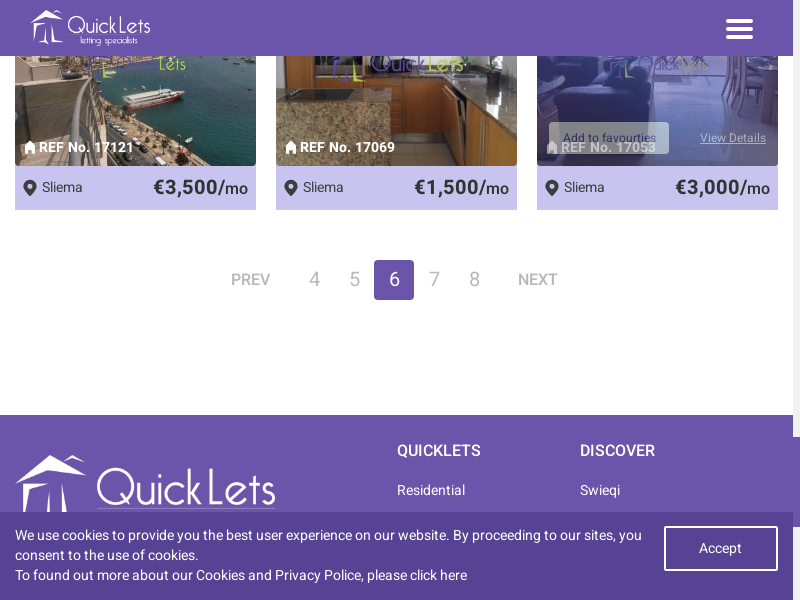

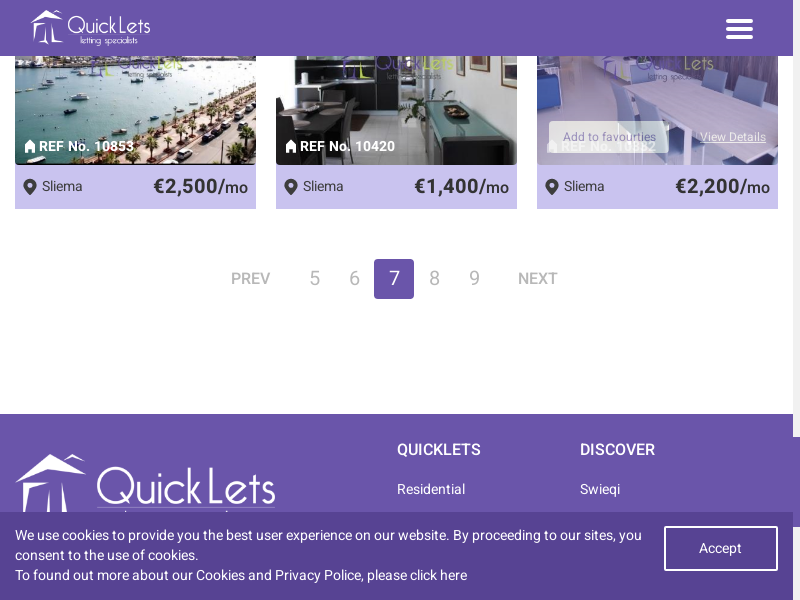

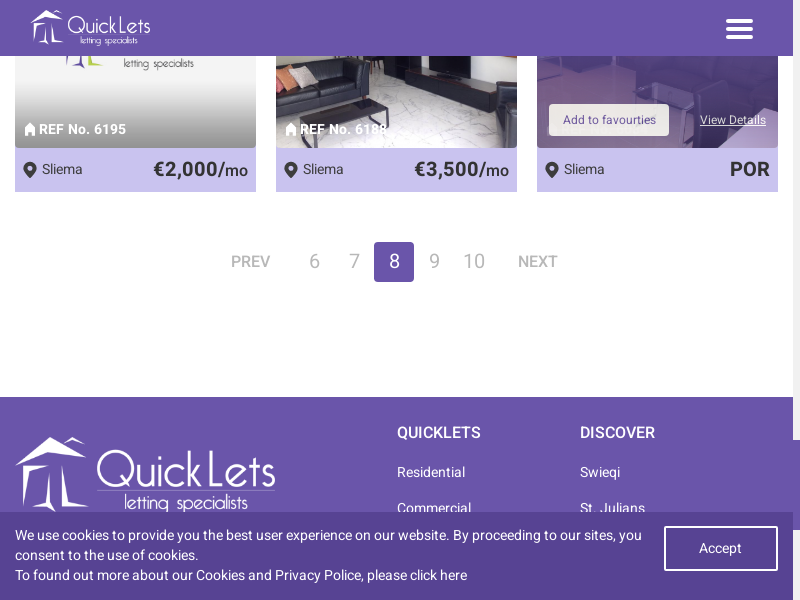

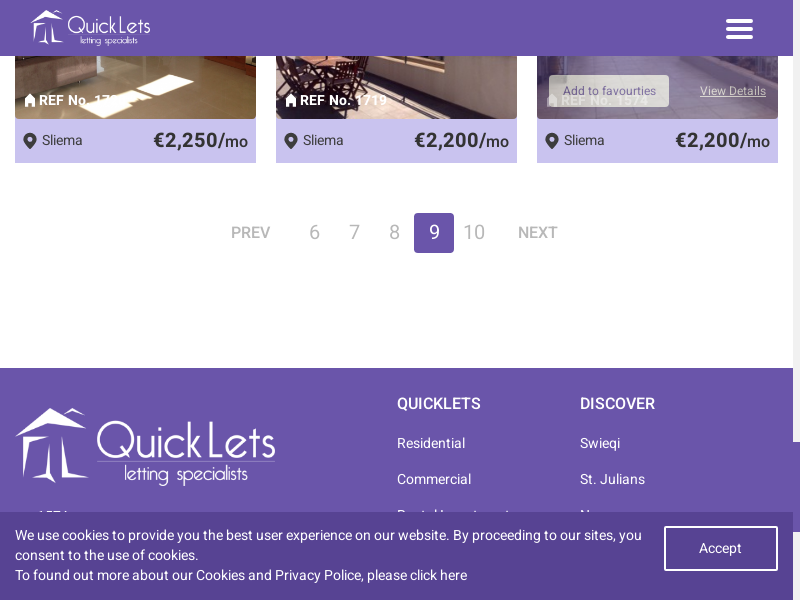

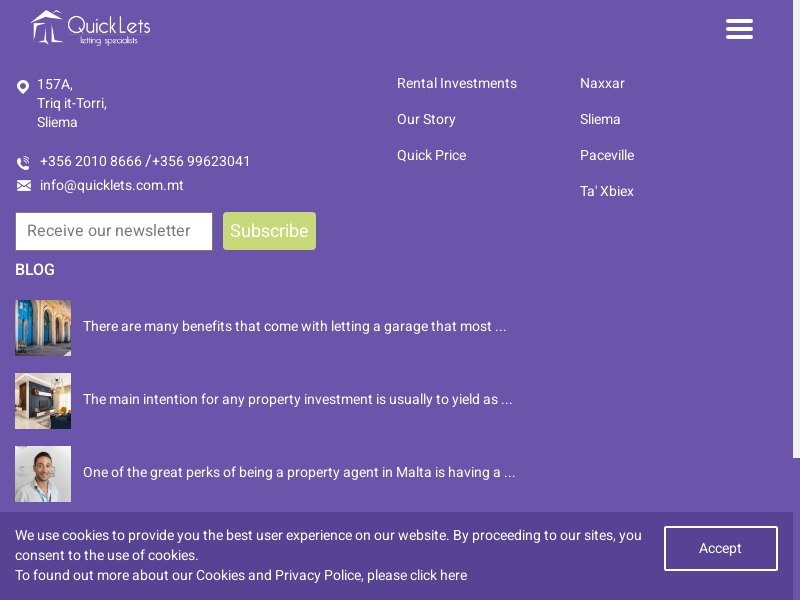

Error on iteration 10


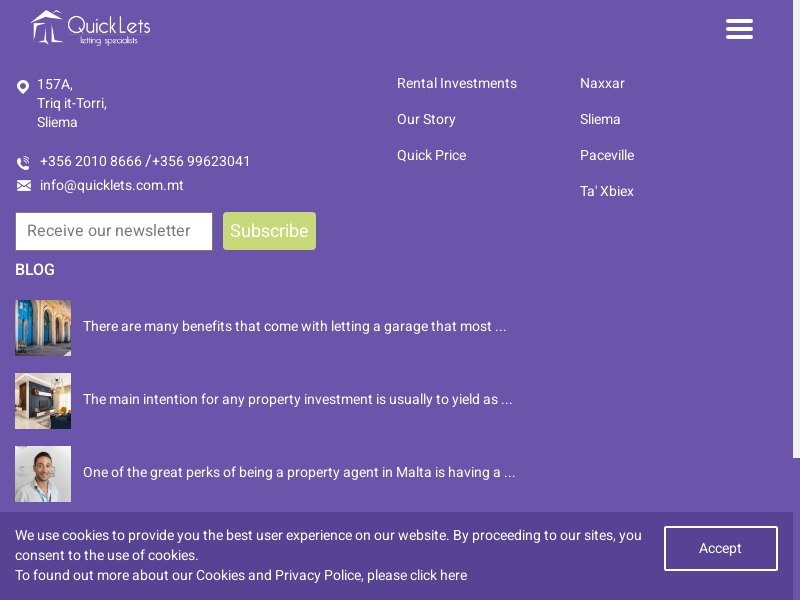

Error on iteration 11


In [ ]:
Nrow = 0
z=1
while (Nrow <= resultNum):
  try:
    if z == 1:
      combined = returndat()
      Nrow = len(combined)
    else:
      newdata = returndat()
      combined = combined.append(newdata)
      Nrow = len(combined)
    Scroll_down(75)
    ShowScreen()
    PageBtn = wd.find_elements_by_css_selector(".pagination_ajax")
    NxtBtn = PageBtn[len(PageBtn)-1]
    NxtBtn.click()
    time.sleep(4)
  except:
    print("Error on iteration " + str(z))
  z=z+1

In [ ]:
combined = combined.reset_index().drop(columns=["index"])

Some properties are scraped twice, so we can remove them. In this particular example we have the same amount of properties that were initially indicated in the result page = 283

In [ ]:
combined = combined.drop_duplicates(subset=['linkurl'])
combined["property_type"] = PropType

In [ ]:
combined

,city,price,linkurl,property_type
0,Sliema,1800,https://www.quicklets.com.mt/property-detail/5...,Penthouse
1,Sliema,2500,https://www.quicklets.com.mt/property-detail/5...,Penthouse
2,Sliema,950,https://www.quicklets.com.mt/property-detail/5...,Penthouse
3,Sliema,700,https://www.quicklets.com.mt/property-detail/5...,Penthouse
4,Sliema,2500,https://www.quicklets.com.mt/property-detail/5...,Penthouse
...,...,...,...,...
278,Sliema,4000,https://www.quicklets.com.mt/property-detail/4...,Penthouse
279,Sliema,1600,https://www.quicklets.com.mt/property-detail/3...,Penthouse
280,Sliema,1200,https://www.quicklets.com.mt/property-detail/3...,Penthouse
281,Sliema,2400,https://www.quicklets.com.mt/property-detail/2...,Penthouse


In [ ]:
combined["price"] = [float(x) for x in combined["price"]]

In [ ]:
combined

,city,price,linkurl,property_type
0,Sliema,1800.0,https://www.quicklets.com.mt/property-detail/5...,Penthouse
1,Sliema,2500.0,https://www.quicklets.com.mt/property-detail/5...,Penthouse
2,Sliema,950.0,https://www.quicklets.com.mt/property-detail/5...,Penthouse
3,Sliema,700.0,https://www.quicklets.com.mt/property-detail/5...,Penthouse
4,Sliema,2500.0,https://www.quicklets.com.mt/property-detail/5...,Penthouse
...,...,...,...,...
278,Sliema,4000.0,https://www.quicklets.com.mt/property-detail/4...,Penthouse
279,Sliema,1600.0,https://www.quicklets.com.mt/property-detail/3...,Penthouse
280,Sliema,1200.0,https://www.quicklets.com.mt/property-detail/3...,Penthouse
281,Sliema,2400.0,https://www.quicklets.com.mt/property-detail/2...,Penthouse


Now we can add our properties to a database.

In [ ]:
import sqlite3

def CreateAppendDB():
    db=sqlite3.connect("information.db")
    db.row_factory=sqlite3.Row
    db.execute("create table if not exists Property(property_type text, city text, price float, linkurl text)")
    for x in range(0,len(combined)):
      db.execute("insert into Property(property_type,city,price,linkurl) values(?,?,?,?)",(combined["property_type"][x],combined["city"][x],combined["price"][x],combined["linkurl"][x]))
    db.commit()

CreateAppendDB()


So we have managed to create a Database and a table with these results!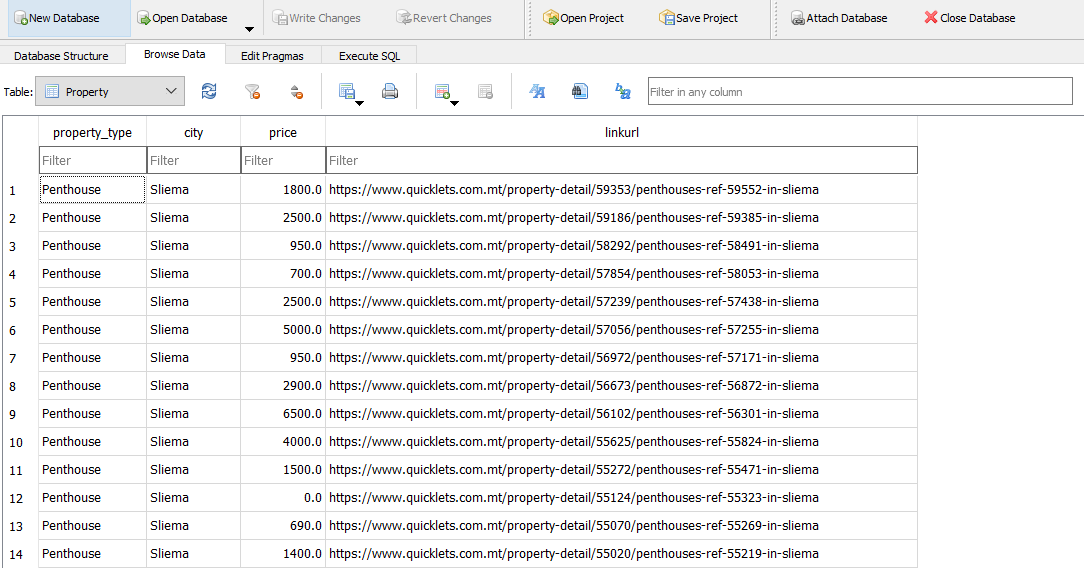